<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/eden-branch/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optional: Install HDBSCAN

In [2]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.8 MB/s eta 0:00:00


Importing Required Libraries

In [3]:
import glob
import numpy as np
import pandas as pd
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

Fetch and Prepare Crime Datasets from GitHub

In [4]:
import os
import zipfile

# הורדת הנתונים מה-GitHub
!git clone https://github.com/orifelszer/CrimeData.git

# הגדרת התיקייה לאחר ההורדה
zip_folder = 'CrimeData'

# הגדרת נתיבים ישירים לשני הקבצים
zip_files = [
    os.path.join(zip_folder, 'Clean_data_unsupervised_part1.zip'),
    os.path.join(zip_folder, 'Clean_data_unsupervised_part2.zip')
]

# רשימה לשמירת נתיבי הקבצים שנפרסו
extracted_folders = []

# פריסת קבצי ה-ZIP
for zip_file in zip_files:
    extract_path = zip_file.replace('.zip', '')  # יצירת שם תיקייה לפי שם הקובץ

    # בדיקה אם הקובץ קיים
    if os.path.exists(zip_file):
        # בדיקה אם התיקייה כבר נפרסה
        if not os.path.exists(extract_path):
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Extracted: {zip_file} -> {extract_path}")
        else:
            print(f"Skipped: {zip_file} (Already extracted)")
    else:
        print(f"File not found: {zip_file}")

    extracted_folders.append(extract_path)

Cloning into 'CrimeData'...
remote: Enumerating objects: 976, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 976 (delta 234), reused 150 (delta 150), pack-reused 678 (from 2)
Receiving objects: 100% (976/976), 301.03 MiB | 33.89 MiB/s, done.
Resolving deltas: 100% (516/516), done.
Extracted: CrimeData/Clean_data_unsupervised_part1.zip -> CrimeData/Clean_data_unsupervised_part1
Extracted: CrimeData/Clean_data_unsupervised_part2.zip -> CrimeData/Clean_data_unsupervised_part2
Combined dataset contains 1686927 rows and 19 columns.


In [ ]:
# איחוד קבצי CSV שפורסו
dataframes = []

for folder in extracted_folders:
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.csv'):
            df_temp = pd.read_csv(file_path)
            dataframes.append(df_temp)

# איחוד כל הנתונים למסגרת נתונים אחת
combined_df = pd.concat(dataframes, ignore_index=True)

# הצגת מסגרת הנתונים המאוחדת
print(f"Combined dataset contains {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")

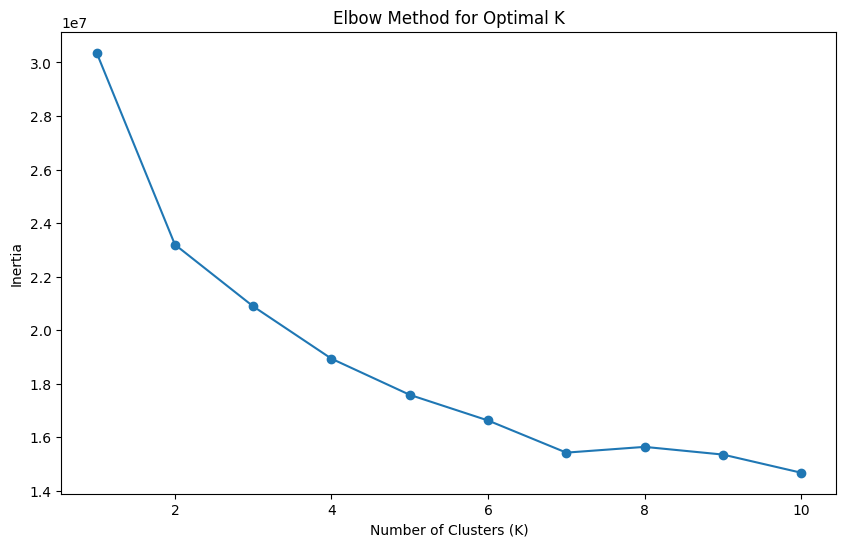

In [5]:
# הסרת עמודת המזהה עבור אשכולות
df_kmeans = combined_df.drop(columns=['FictiveIDNumber'])

# ביצוע סטנדרטיזציה על הנתונים (חשוב עבור K-Means)
scaler = StandardScaler()
df_kmeans_scaled = scaler.fit_transform(df_kmeans)

# בחינת מספר אשכולות מתאים באמצעות Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# הצגת גרף Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


In [6]:
# חשוב: הרצת KMeans על הדאטה המנורמל בלבד
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(df_kmeans_scaled)

# הוספת עמודת האשכול חזרה לדאטה המקורי (לא המנורמל)
df_kmeans['Cluster'] = clusters

# דגימה מתוך כל אשכול
# דגימה מתוך כל אשכול לפי האשכולות שהוגדרו
df_sample = df_kmeans.groupby('Cluster').apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)

<ipython-input-6-2bb3b8615827>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_kmeans.groupby('Cluster').apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)


In [7]:
numeric_columns = ['YeshuvCrimeRate', 'CrimeTrend', 'CrimeTrend_CrimeRate',
                   'StationCrimeRateAvg', 'YeshuvHistoricalCrimeRate', 'StationsNearbyCount']

for column in numeric_columns:
    stat, p_value = ks_2samp(df_kmeans[column], df_sample[column])
    print(f"{column}: p-value = {p_value:.5f}")
    if p_value > 0.05:
        print("✅ No significant difference detected!")
    else:
        print("⚠️ Significant difference detected!")

YeshuvCrimeRate: p-value = 0.99967
✅ No significant difference detected!
CrimeTrend: p-value = 0.99827
✅ No significant difference detected!
CrimeTrend_CrimeRate: p-value = 1.00000
✅ No significant difference detected!
StationCrimeRateAvg: p-value = 0.99995
✅ No significant difference detected!
YeshuvHistoricalCrimeRate: p-value = 0.99967
✅ No significant difference detected!
StationsNearbyCount: p-value = 1.00000
✅ No significant difference detected!


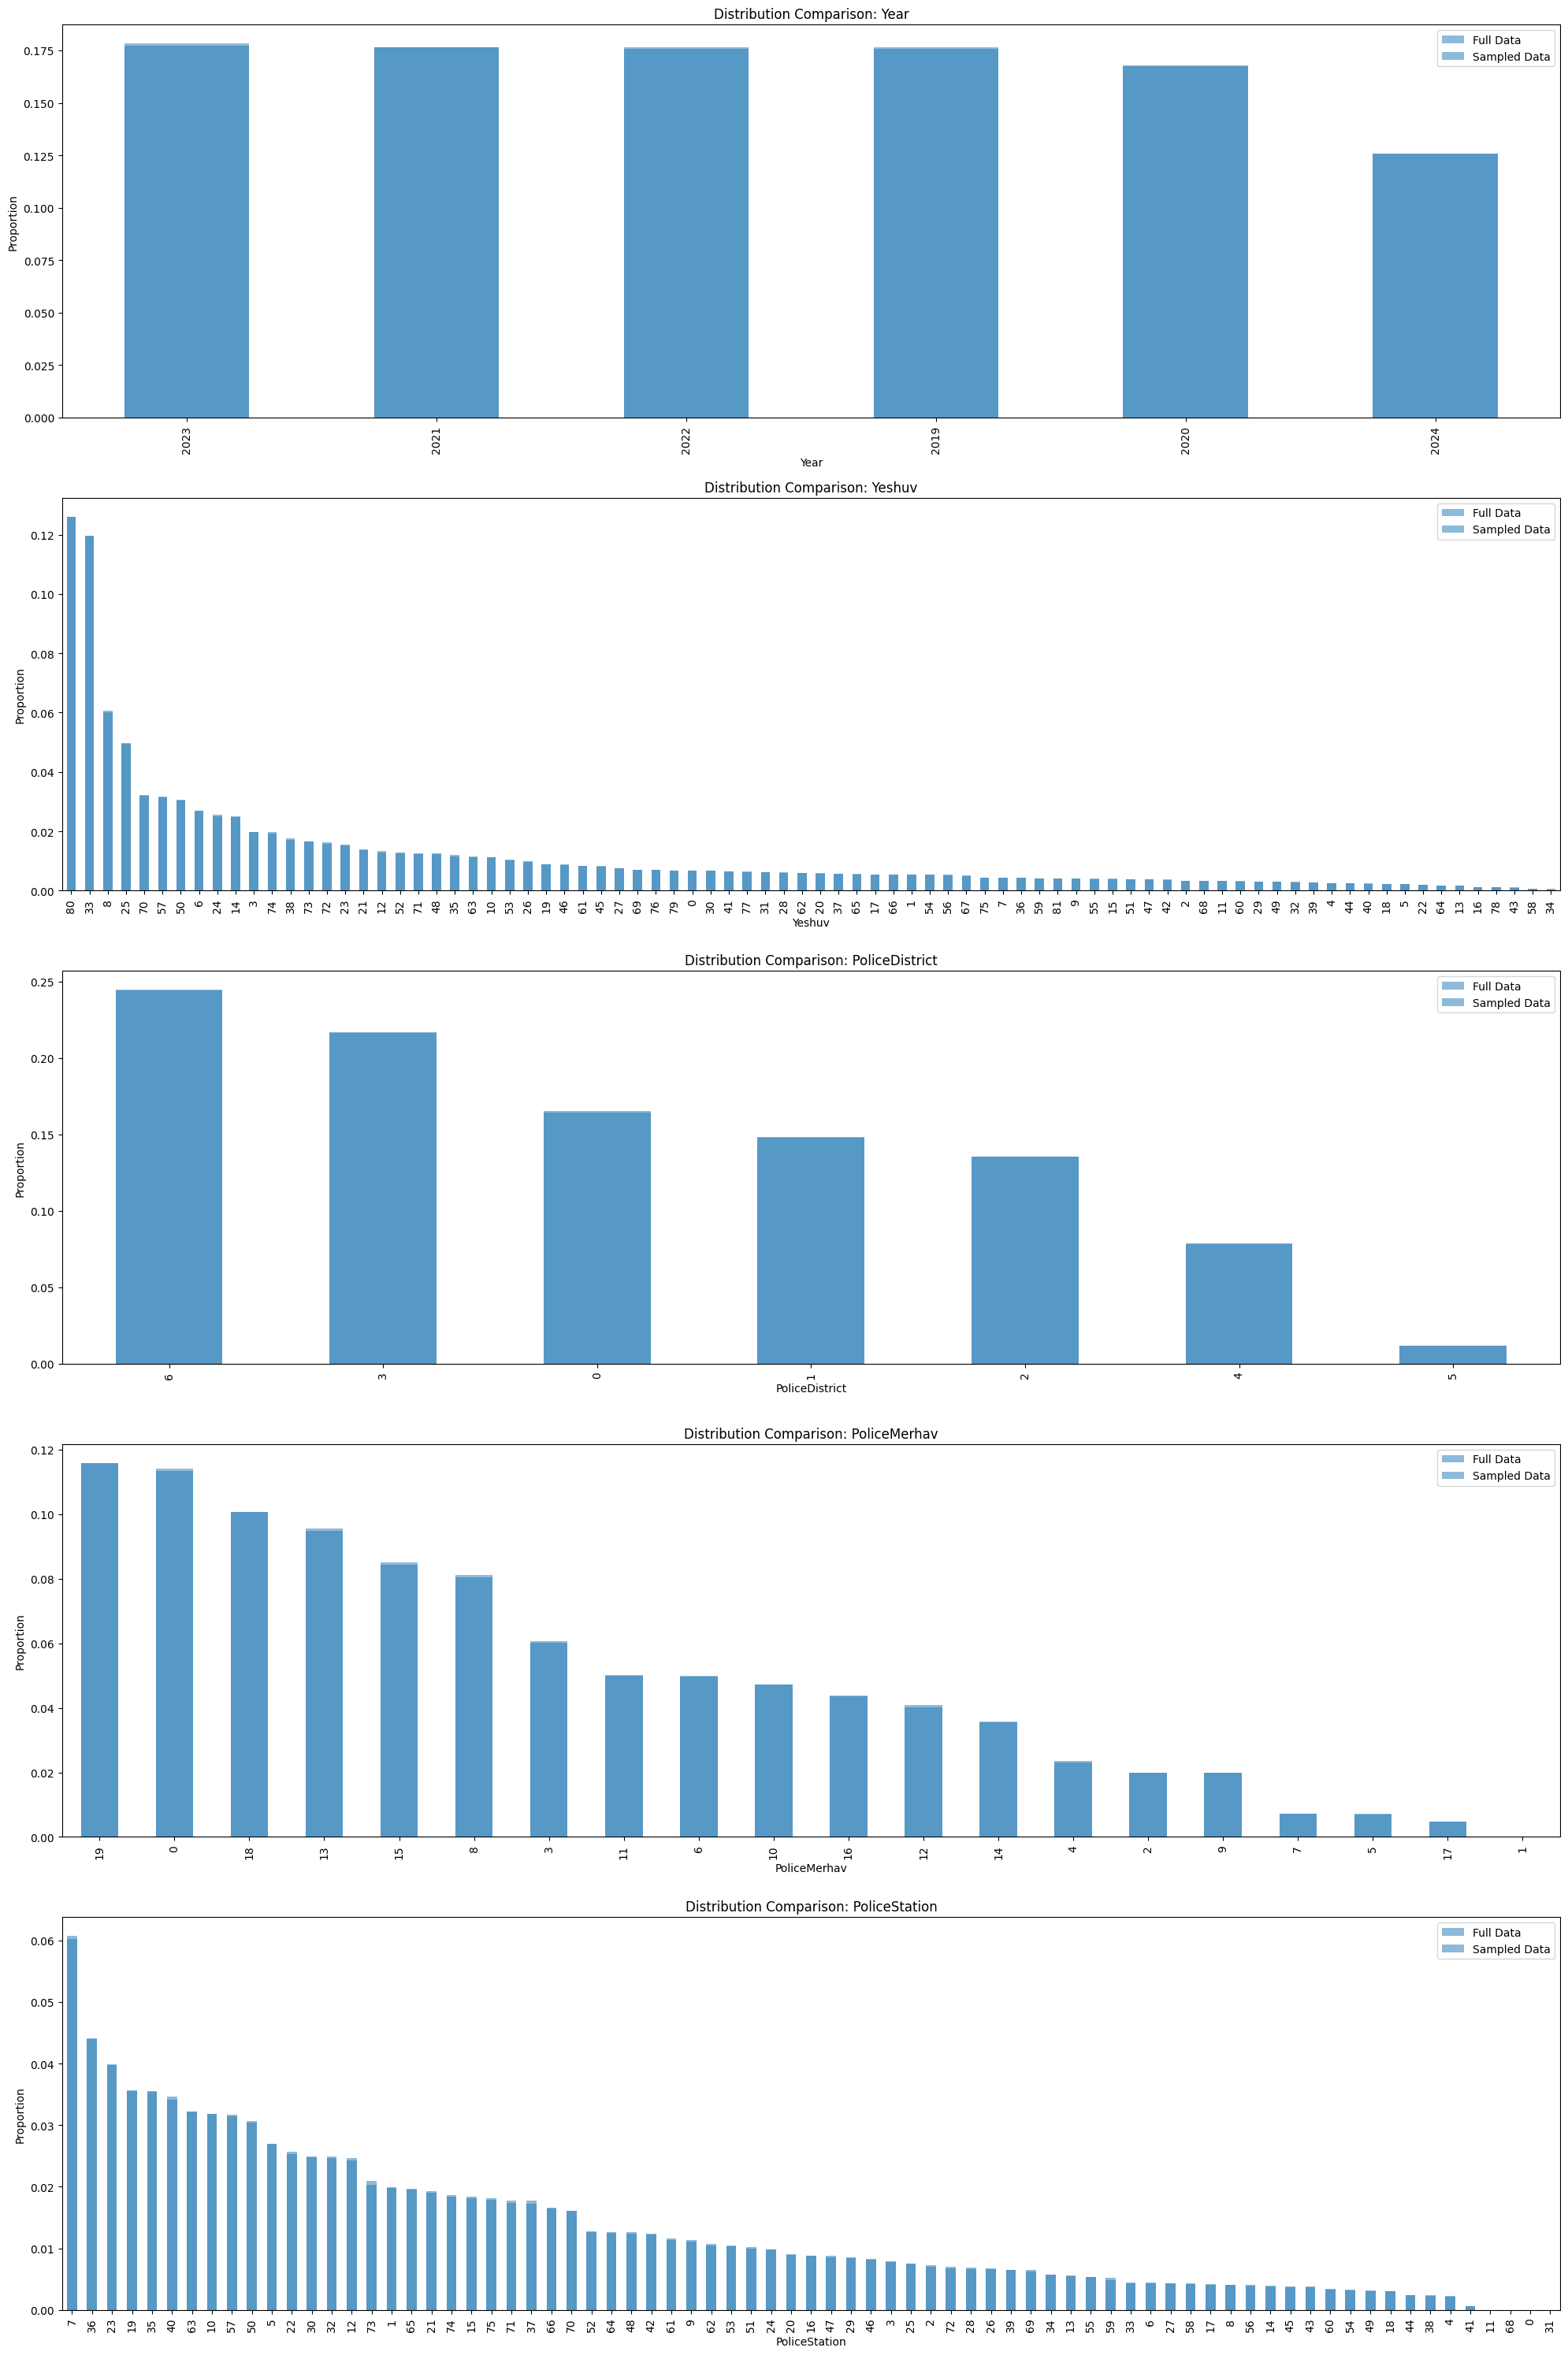

In [8]:
# רשימת עמודות קטגוריות להשוואה
categorical_columns = ['Year', 'Yeshuv', 'PoliceDistrict', 'PoliceMerhav', 'PoliceStation']

# יצירת גרפים להשוואת התפלגות
plt.figure(figsize=(20, 30))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    df_kmeans[column].value_counts(normalize=True).plot(kind='bar', alpha=0.5, label='Full Data')
    df_sample[column].value_counts(normalize=True).plot(kind='bar', alpha=0.5, label='Sampled Data')
    plt.title(f'Distribution Comparison: {column}')
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.legend()

plt.tight_layout()
plt.show()

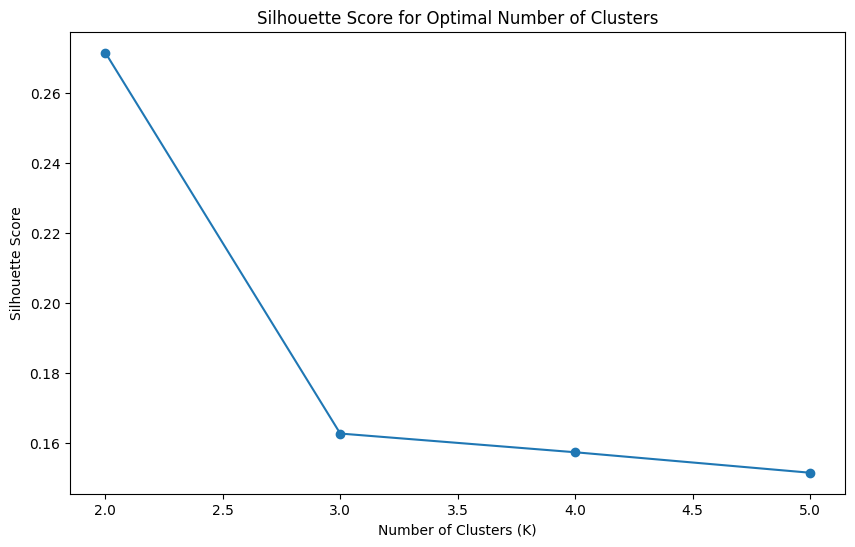

Optimal number of clusters based on Silhouette Score: 2


In [29]:
# ✅ חישוב Silhouette Score עבור ערכי K מ-2 עד 10
silhouette_scores = []
k_values = range(2, 6)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_sample)
    score = silhouette_score(df_sample, cluster_labels)
    silhouette_scores.append(score)

# ✅ גרף להצגת Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# ✅ הצגת מספר האשכולות האופטימלי לפי Silhouette
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")


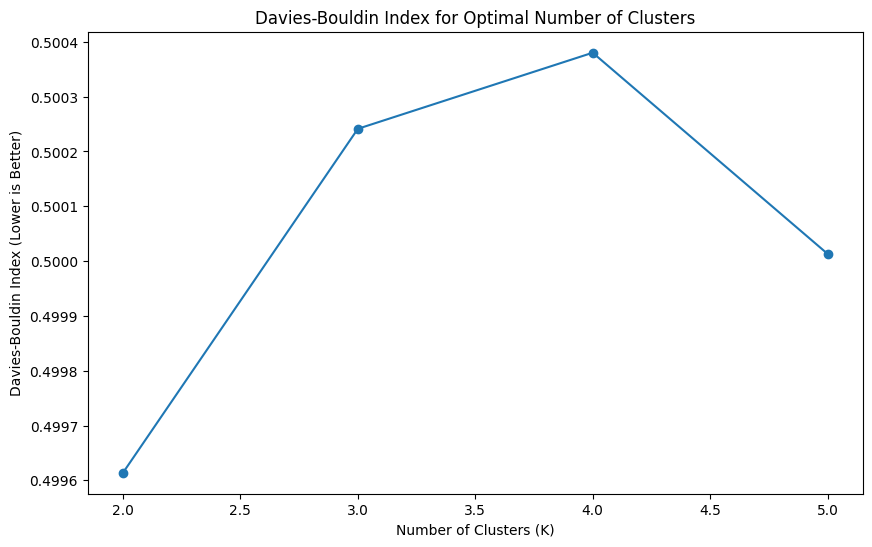

Optimal number of clusters based on Davies-Bouldin Index: 2


In [10]:
# ✅ חישוב מדד Davies-Bouldin עבור K=2 עד 10
davies_bouldin_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(combined_df)
    score = davies_bouldin_score(combined_df, cluster_labels)
    davies_bouldin_scores.append(score)

# ✅ גרף להצגת Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index (Lower is Better)')
plt.show()

# ✅ קביעת K האופטימלי לפי המדד (נמוך יותר טוב יותר)
optimal_k_db = k_values[np.argmin(davies_bouldin_scores)]
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_k_db}")


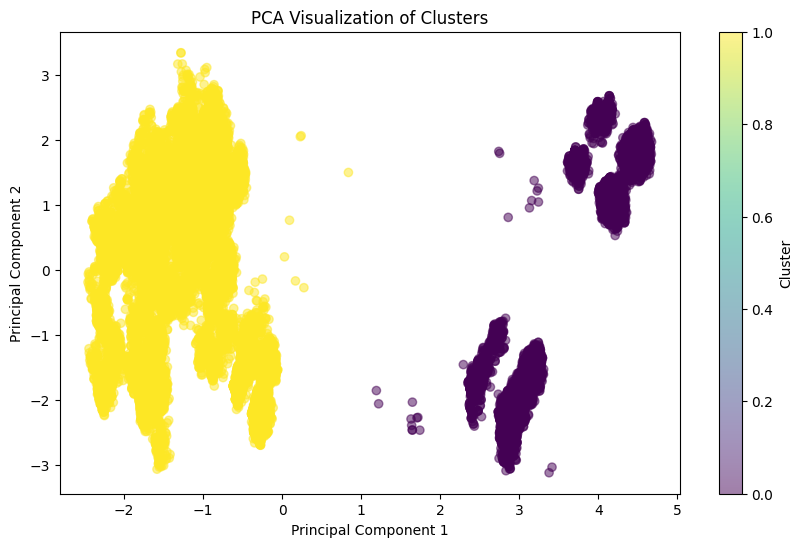

In [11]:
# הרצת PCA על הדאטה המנורמל
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_sample)

# הרצת KMeans עם K=2 כפי שנבחר מהמדדים
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df_sample)

# ציור הגרף
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [15]:


# יצירת DataFrame עם הנתונים והאשכולות
df_with_clusters = pd.DataFrame(df_sample, columns=[f'Feature_{i}' for i in range(df_sample.shape[1])])
df_with_clusters['Cluster'] = clusters  # הוספת עמודת האשכולות

# סטטיסטיקות בסיסיות על האשכולות
unique, counts = np.unique(clusters, return_counts=True)
cluster_stats = pd.DataFrame({'Cluster': unique, 'Count': counts})


# יצירת טבלה של סטטיסטיקות בסיסיות על האשכולות
cluster_stats = pd.DataFrame({'Cluster': unique, 'Count': counts})
display(cluster_stats)

# הצגת ממוצעים לכל משתנה בתוך כל אשכול
cluster_summary = df_with_clusters.groupby('Cluster').mean()
display(cluster_summary)



,Cluster,Count
0,0,12177
1,1,37823


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17
Cluster,,,,,,,,,,,,,,,,,,
0,-0.028396,0.573713,0.532562,-0.261015,0.564645,-0.087075,-0.095717,0.068937,0.004658,-0.005696,-0.003408,1.659319,0.027426,1.646728,1.657156,1.659319,-0.793482,0.630147
1,0.005114,-0.195499,-0.173620,0.075012,-0.192991,0.022805,0.024684,-0.028072,-0.001938,0.013094,0.004841,-0.543302,-0.003732,-0.538332,-0.543876,-0.543302,0.253616,-0.209520


In [16]:
# הרצת DBSCAN
dbscan = DBSCAN(eps=3.5, min_samples=10)
dbscan_clusters = dbscan.fit_predict(df_sample)

# בדיקת מספר האשכולות שזוהו (מספרים חיוביים הם אשכולות, -1 זה רעש)
unique_dbscan, counts_dbscan = np.unique(dbscan_clusters, return_counts=True)
dbscan_stats = pd.DataFrame({'Cluster': unique_dbscan, 'Count': counts_dbscan})
print(dbscan_stats)

# בדיקת Silhouette Score של DBSCAN
if len(unique_dbscan) > 1:
    score_dbscan = silhouette_score(df_sample, dbscan_clusters)
    print(f"Silhouette Score for DBSCAN: {score_dbscan:.2f}")
else:
    print("DBSCAN identified only one cluster. Silhouette Score not applicable.")


   Cluster  Count
0       -1      3
1        0  43777
2        1   6220
Silhouette Score for DBSCAN: 0.23


In [17]:

# ✅ הרצת KMeans עם מספר האשכולות שנבחר (K=2)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_full = kmeans.fit_predict(df_kmeans_scaled)

# ✅ הוספת עמודת האשכולות לדאטה המקורי (לא מנורמל)
df_kmeans['Cluster'] = clusters_full

In [18]:
df_kmeans['Cluster'].value_counts(normalize=True) * 100


,proportion
Cluster,
1,75.422292
0,24.577708


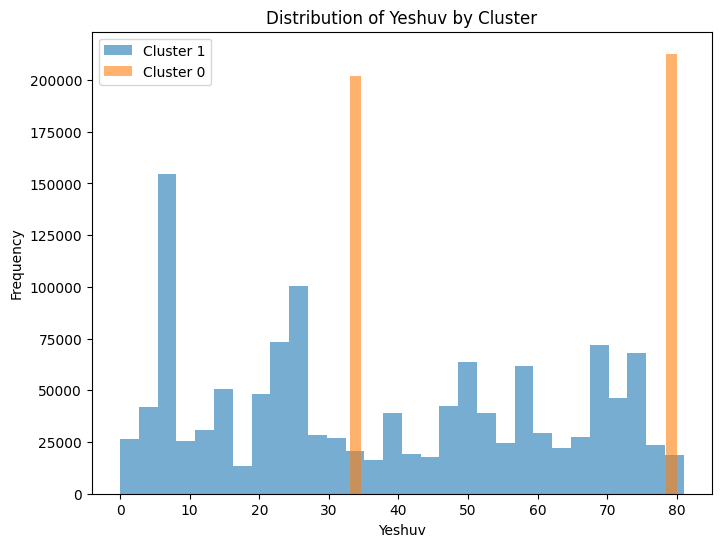

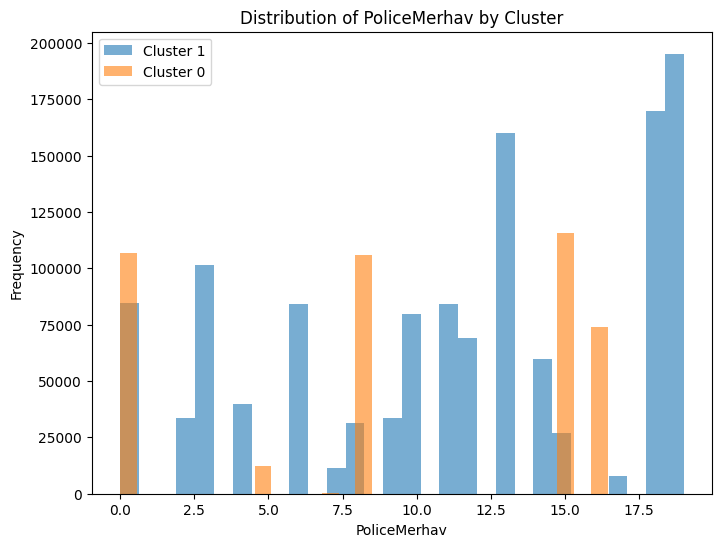

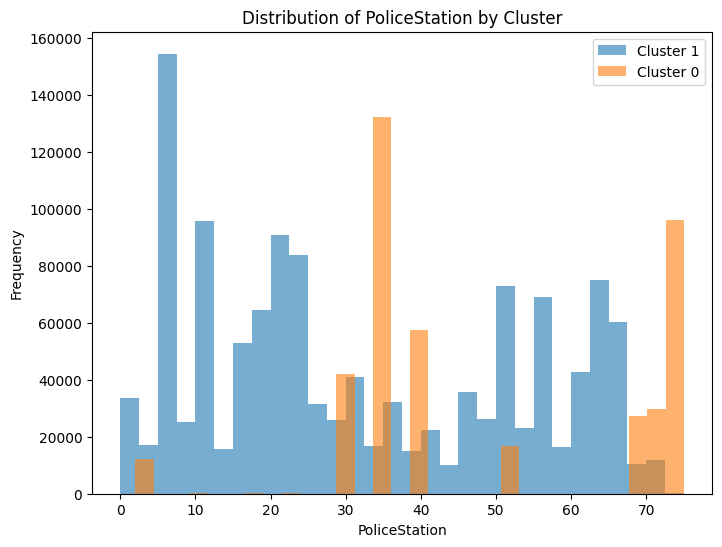

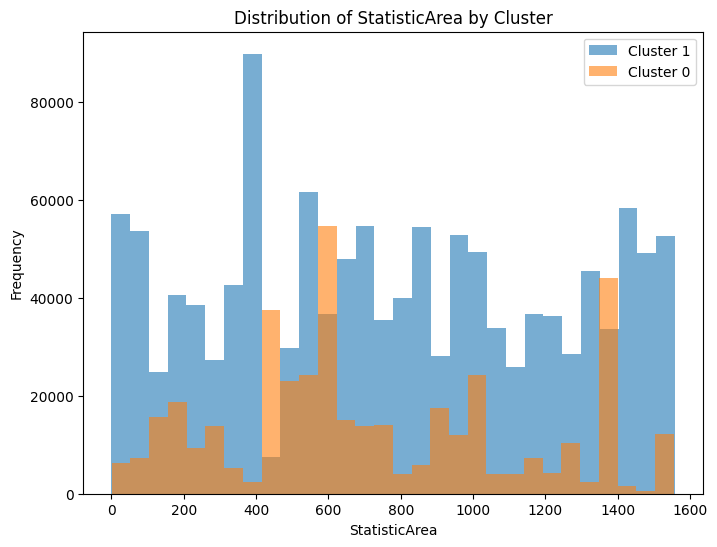

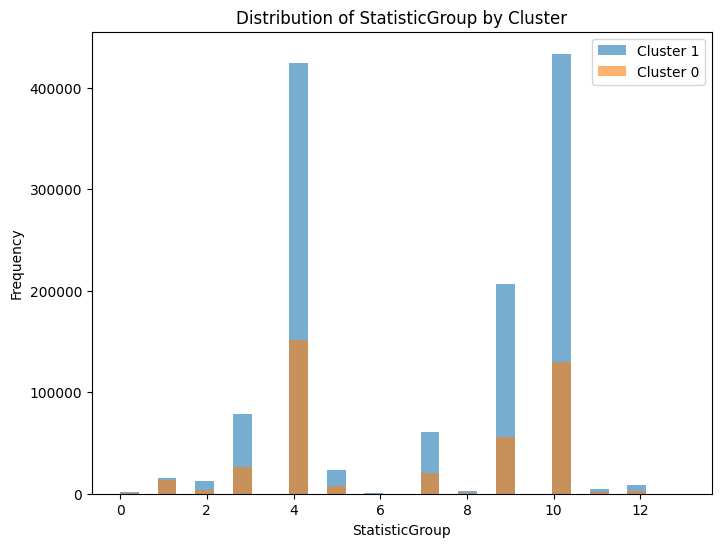

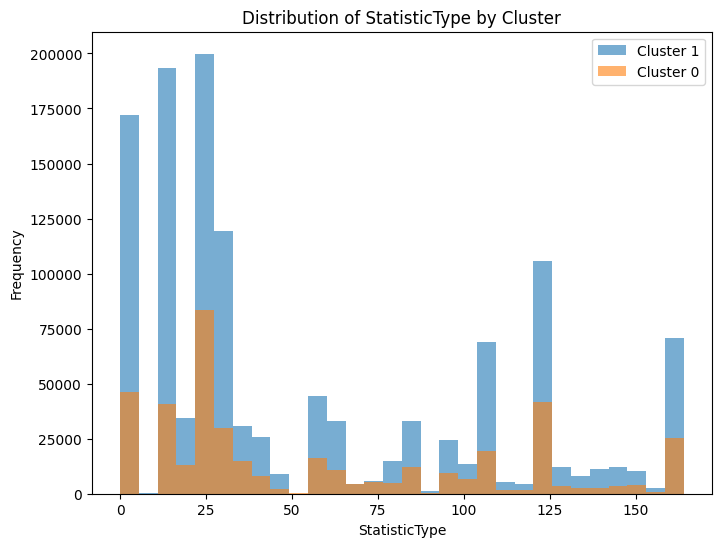

In [19]:
# ✅ הצגת פיזור הנתונים לפי האשכולות עבור מספר משתנים מרכזיים
selected_features = ['Yeshuv', 'PoliceMerhav', 'PoliceStation', 'StatisticArea', 'StatisticGroup', 'StatisticType']
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    for cluster in df_kmeans['Cluster'].unique():
        plt.hist(df_kmeans[df_kmeans['Cluster'] == cluster][feature],
                 alpha=0.6, label=f'Cluster {cluster}', bins=30)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [20]:

# ✅ חישוב ממוצעים וסטיות תקן של משתנים מרכזיים
central_features =['YeshuvCrimeRate', 'CrimeTrend', 'CrimeTrend_CrimeRate', 'StationCrimeRateAvg', 'YeshuvHistoricalCrimeRate', 'StationsNearbyCount']
cluster_means_selected = df_kmeans.groupby('Cluster')[central_features].mean()
cluster_stds_selected = df_kmeans.groupby('Cluster')[central_features].std()

# ✅ הצגת התוצאות בפורמט טבלאי רגיל במחברת Jupyter
print("Cluster Means (Selected Features):")
display(cluster_means_selected)

print("Cluster Standard Deviations (Selected Features):")
display(cluster_stds_selected)


Cluster Means (Selected Features):


,YeshuvCrimeRate,CrimeTrend,CrimeTrend_CrimeRate,StationCrimeRateAvg,YeshuvHistoricalCrimeRate,StationsNearbyCount
Cluster,,,,,,
0,2.429438,4.702277,2.268856,2.475215,2.429438,2.768829
1,0.401975,4.658233,0.376978,0.406446,0.401975,3.655480


Cluster Standard Deviations (Selected Features):


,YeshuvCrimeRate,CrimeTrend,CrimeTrend_CrimeRate,StationCrimeRateAvg,YeshuvHistoricalCrimeRate,StationsNearbyCount
Cluster,,,,,,
0,0.063104,1.771774,0.226164,0.117079,0.063104,0.751362
1,0.337668,1.821791,0.318766,0.343403,0.337668,0.757808


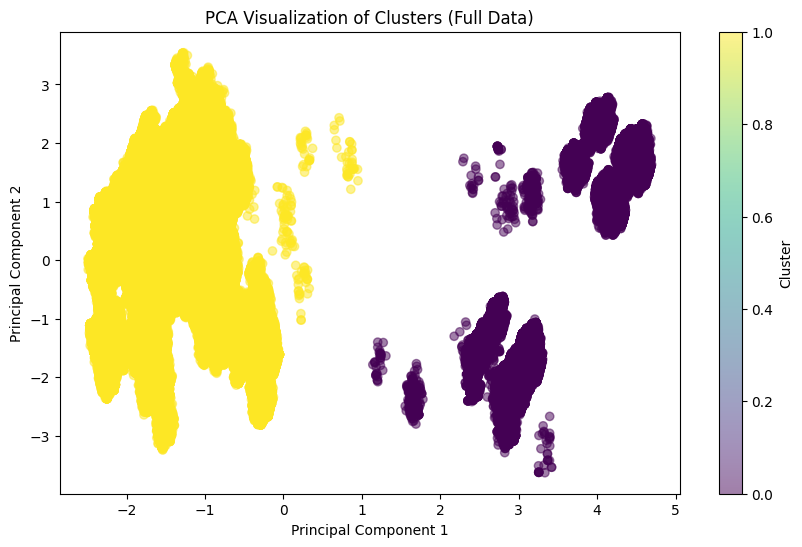

In [21]:
# ✅ הרצת PCA להצגת האשכולות ויזואלית
pca = PCA(n_components=2)  # הפחתה לשני ממדים לצורך ויזואליזציה
df_pca = pca.fit_transform(df_kmeans_scaled)

# ✅ יצירת גרף PCA
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_kmeans['Cluster'], cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Clusters (Full Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [22]:
# ✅ שימוש באותו מדגם קיים (df_sample)
df_sample_scaled = df_sample  # אין צורך לשנות, כבר מדגם מוכן

# ✅ הרצת DBSCAN על המדגם הקיים
dbscan = DBSCAN(eps=3.5, min_samples=10)
dbscan_clusters = dbscan.fit_predict(df_sample_scaled)

# ✅ חישוב Silhouette Score עבור DBSCAN (רק אם זוהו יותר מאשכול אחד)
if len(set(dbscan_clusters)) > 1:
    silhouette_dbscan = silhouette_score(df_sample_scaled, dbscan_clusters)
else:
    silhouette_dbscan = -1

# ✅ הרצת HDBSCAN על המדגם הקיים
hdbscan = HDBSCAN(min_cluster_size=50, min_samples=10)
hdbscan_clusters = hdbscan.fit_predict(df_sample_scaled)

# ✅ חישוב Silhouette Score עבור HDBSCAN (רק אם זוהו יותר מאשכול אחד)
if len(set(hdbscan_clusters)) > 1:
    silhouette_hdbscan = silhouette_score(df_sample_scaled, hdbscan_clusters)
else:
    silhouette_hdbscan = -1

# ✅ הצגת תוצאות השוואתיות
print(f"Silhouette Score for KMeans (Sampled): {max(silhouette_scores):.2f}")
print(f"Silhouette Score for DBSCAN (Sampled): {silhouette_dbscan:.2f}")
print(f"Silhouette Score for HDBSCAN (Sampled): {silhouette_hdbscan:.2f}")

print(f"Number of clusters (KMeans): {optimal_k_silhouette}")
print(f"Number of clusters (DBSCAN): {len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)}")
print(f"Number of clusters (HDBSCAN): {len(set(hdbscan_clusters)) - (1 if -1 in hdbscan_clusters else 0)}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score for KMeans (Sampled): 0.27
Silhouette Score for DBSCAN (Sampled): 0.23
Silhouette Score for HDBSCAN (Sampled): -0.00
Number of clusters (KMeans): 2
Number of clusters (DBSCAN): 2
Number of clusters (HDBSCAN): 185


In [27]:
# הצגת קורלציות בין תחנות קרובות לפשיעה באשכולות
numeric_columns = ['YeshuvCrimeRate', 'StationsNearbyCount']
correlation_results = {}

# חישוב מתאם פירסון לכל אשכול
for cluster in df_kmeans['Cluster'].unique():
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster]
    corr, p_value = pearsonr(cluster_data['YeshuvCrimeRate'], cluster_data['StationsNearbyCount'])
    correlation_results[f'Cluster {cluster}'] = {'Correlation': corr, 'p_value': p_value}

# הצגת קורלציה
correlation_df = pd.DataFrame(correlation_results).transpose()
print("Pearson Correlation between Crime Rate and Stations Nearby Count:")
print(correlation_df)

Pearson Correlation between Crime Rate and Stations Nearby Count:
           Correlation        p_value
Cluster 1     0.019693  2.421084e-109
Cluster 0     0.998787   0.000000e+00


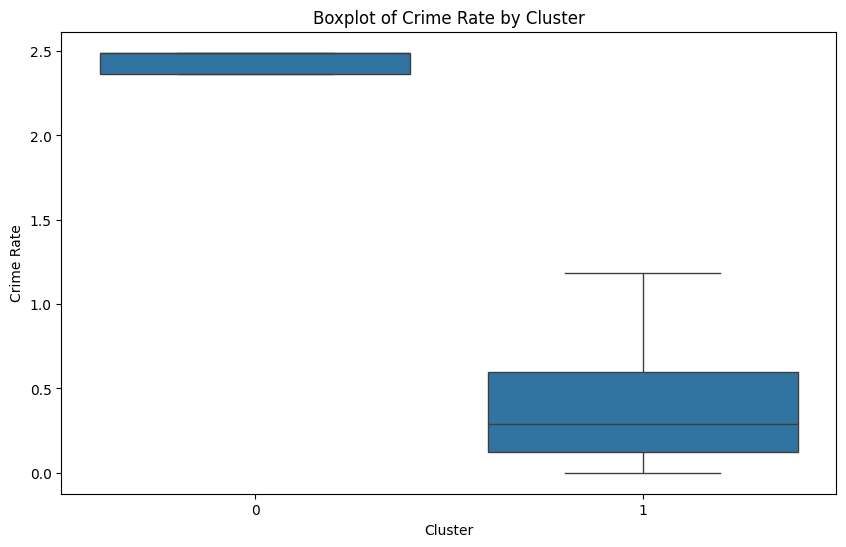

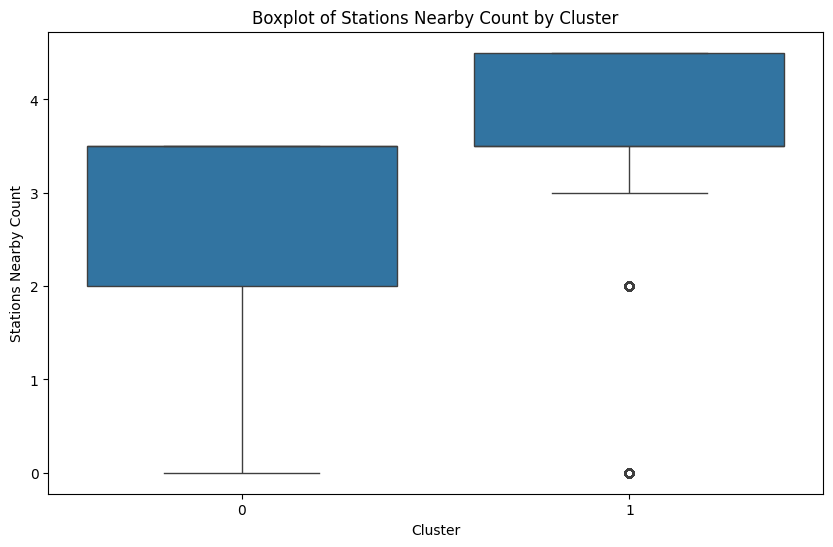

In [28]:
# גרף Boxplot להצגת ההבדלים באשכולות
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_kmeans, x='Cluster', y='YeshuvCrimeRate')
plt.title('Boxplot of Crime Rate by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Crime Rate')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_kmeans, x='Cluster', y='StationsNearbyCount')
plt.title('Boxplot of Stations Nearby Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Stations Nearby Count')
plt.show()